# 股票历史涨跌幅分析工具
本Notebook用于分析股票在出现特定涨跌幅后的历史表现，支持生成可视化图表和HTML报告。

## 导入必要的库

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import io
import base64
import os
import requests
import logging
import warnings
import json
import scipy.stats as stats
from IPython.display import display, HTML, Image

# 基础配置
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
proxy_url = "http://127.0.0.1:7890"
os.environ["HTTP_PROXY"] = proxy_url
os.environ["HTTPS_PROXY"] = proxy_url

## 股票波动率分析器类

In [30]:
class StockVolatilityAnalyzer:
    def __init__(self, ticker, target_change, period='max', use_cache=True):
        self.ticker = ticker
        self.target_change = target_change
        self.period = period
        self.use_cache = use_cache
        self.data = None
        self.ticker_info = None
        self.signal_dates = []
        self.future_returns = {}
        self.periods = [1, 7, 15, 30, 60, 180, 360]
        self.cache_dir = os.path.join(os.path.expanduser("~"), ".stock_analysis_cache")
        os.makedirs(self.cache_dir, exist_ok=True)

    # 数据获取
    def fetch_data(self):
        try:
            cache_file = os.path.join(self.cache_dir, f"{self.ticker}_{self.period}.csv")
            if self.use_cache and os.path.exists(cache_file):
                try:
                    self.data = pd.read_csv(cache_file, index_col=0, parse_dates=True)
                    logging.info(f"从缓存加载 {self.ticker} 的数据")
                    if not self.data.empty:
                        try:
                            stock = yf.Ticker(self.ticker)
                            self.ticker_info = stock.info
                        except:
                            self.ticker_info = {"shortName": self.ticker}
                        return True
                except Exception as e:
                    logging.warning(f"读取缓存文件失败: {str(e)}")

            logging.info(f"从API获取 {self.ticker} 的数据，周期: {self.period}")
            stock = yf.Ticker(self.ticker)
            self.data = stock.history(period=self.period)
            if self.data.empty:
                logging.error(f"无法获取 {self.ticker} 的数据")
                return False
            try:
                self.ticker_info = stock.info
            except:
                self.ticker_info = {"shortName": self.ticker}
            if self.use_cache:
                try:
                    self.data.to_csv(cache_file)
                    logging.info(f"数据已缓存到 {cache_file}")
                except Exception as e:
                    logging.warning(f"保存缓存失败: {str(e)}")
            return True
        except Exception as e:
            logging.error(f"获取数据时出错: {str(e)}")
            return False

    # 信号识别
    def find_signal_dates(self):
        try:
            if self.data is None or self.data.empty:
                return False
            self.data['Daily_Change'] = self.data['Close'].pct_change() * 100
            if self.target_change > 0:
                signal_mask = self.data['Daily_Change'] >= self.target_change
            else:
                signal_mask = self.data['Daily_Change'] <= self.target_change
            self.signal_dates = self.data[signal_mask].index.tolist()
            if not self.signal_dates:
                logging.warning(f"未找到 {self.ticker} 单日涨跌幅达到 {self.target_change}% 的日期")
                return False
            logging.info(f"找到 {len(self.signal_dates)} 个符合条件的日期")
            return True
        except Exception as e:
            logging.error(f"查找信号日期时出错: {str(e)}")
            return False

    # 收益计算
    def calculate_future_returns(self):
        try:
            if not self.signal_dates:
                return False
            for period in self.periods:
                returns_list = []
                for signal_date in self.signal_dates:
                    try:
                        signal_idx = self.data.index.get_loc(signal_date)
                        if signal_idx + period < len(self.data):
                            signal_close = self.data.iloc[signal_idx]['Close']
                            future_close = self.data.iloc[signal_idx + period]['Close']
                            return_pct = (future_close - signal_close) / signal_close * 100
                            returns_list.append(return_pct)
                    except Exception:
                        continue
                self.future_returns[period] = returns_list
            return True
        except Exception as e:
            logging.error(f"计算后续收益率时出错: {str(e)}")
            return False

    # 统计分析
    def generate_statistics(self):
        stats_results = {}
        for period, returns in self.future_returns.items():
            if returns:
                arr = np.array(returns)
                stats_results[period] = {
                    'count': len(returns),
                    'mean': np.mean(arr),
                    'median': np.median(arr),
                    'std': np.std(arr),
                    'min': np.min(arr),
                    'max': np.max(arr),
                    'positive_rate': (np.sum(arr > 0) / len(arr)) * 100,
                    'skewness': stats.skew(arr),
                    'kurtosis': stats.kurtosis(arr)
                }
        return stats_results

    # 绘图函数
    def plot_price_with_signals(self, display_in_notebook=True):
        try:
            plt.figure(figsize=(14, 7))
            plt.plot(self.data.index, self.data['Close'], 'b-', alpha=0.7, linewidth=1.5, label='收盘价')
            signal_prices = [self.data.loc[date]['Close'] for date in self.signal_dates if date in self.data.index]
            plt.scatter(self.signal_dates, signal_prices, color='red', s=50, alpha=0.7, edgecolors='black', linewidths=1, label=f'涨跌幅{self.target_change}%')
            plt.title(f'{self.ticker} 价格走势与信号点', fontsize=14)
            plt.xlabel('日期', fontsize=12)
            plt.ylabel('价格', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=10)
            ax = plt.gca()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            if len(self.data) > 1000:
                ax.xaxis.set_major_locator(mdates.YearLocator())
            elif len(self.data) > 365:
                ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
            else:
                ax.xaxis.set_major_locator(mdates.MonthLocator())
            plt.xticks(rotation=45)
            plt.tight_layout()

            if display_in_notebook:
                plt.show()

            buffer = io.BytesIO()
            plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
            buffer.seek(0)
            image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
            plt.close()
            return image_base64
        except Exception as e:
            logging.error(f"绘制价格走势图时出错: {str(e)}")
            return None

    def plot_returns_distribution(self, display_in_notebook=True):
        try:
            plt.figure(figsize=(12, 8))
            n_periods = len(self.future_returns)
            n_cols = min(3, n_periods)
            n_rows = (n_periods + n_cols - 1) // n_cols
            for i, (period, returns) in enumerate(self.future_returns.items()):
                if returns:
                    ax = plt.subplot(n_rows, n_cols, i + 1)
                    n, bins, patches = ax.hist(returns, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
                    mu = np.mean(returns)
                    sigma = np.std(returns)
                    x = np.linspace(min(returns), max(returns), 100)
                    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label=f'正态分布\nμ={mu:.2f}%\nσ={sigma:.2f}%')
                    ax.set_title(f'{period}日收益率分布', fontsize=12)
                    ax.set_xlabel('收益率(%)', fontsize=10)
                    ax.set_ylabel('概率密度', fontsize=10)
                    ax.grid(True, alpha=0.3)
                    ax.legend(fontsize=8)
            plt.suptitle(f'{self.ticker} 在涨跌幅{self.target_change}%后的收益率分布', fontsize=14)
            plt.tight_layout(rect=[0, 0, 1, 0.96])

            if display_in_notebook:
                plt.show()

            buffer = io.BytesIO()
            plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
            buffer.seek(0)
            image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
            buffer.close()
            plt.close()
            return image_base64
        except Exception as e:
            logging.error(f"绘制收益率分布时出错: {str(e)}")
            return None

    def plot_boxplot_comparison(self, display_in_notebook=True):
        try:
            plt.figure(figsize=(12, 6))
            data_to_plot = []
            labels = []
            for period, returns in sorted(self.future_returns.items()):
                if returns:
                    data_to_plot.append(returns)
                    labels.append(f'{period}日')
            box_plot = plt.boxplot(data_to_plot, labels=labels, patch_artist=True,
                                 boxprops=dict(facecolor='skyblue', color='black'),
                                 whiskerprops=dict(color='black'),
                                 capprops=dict(color='black'),
                                 medianprops=dict(color='red', linewidth=2))
            means = [np.mean(data) for data in data_to_plot]
            plt.plot(range(1, len(means) + 1), means, 'ro-', label='均值', linewidth=2)
            plt.title(f'{self.ticker} 在涨跌幅{self.target_change}%后不同周期的收益率分布', fontsize=14)
            plt.xlabel('周期', fontsize=12)
            plt.ylabel('收益率(%)', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=10)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
            plt.tight_layout()

            if display_in_notebook:
                plt.show()

            buffer = io.BytesIO()
            plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
            buffer.seek(0)
            image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
            buffer.close()
            plt.close()
            return image_base64
        except Exception as e:
            logging.error(f"绘制箱线图比较时出错: {str(e)}")
            return None

    def plot_cumulative_returns(self, display_in_notebook=True):
        try:
            plt.figure(figsize=(12, 6))
            cumulative_returns = []
            periods_with_zero = [0] + self.periods
            for period in self.periods:
                if period in self.future_returns and self.future_returns[period]:
                    avg_return = np.mean(self.future_returns[period])
                    cumulative_returns.append(avg_return)
                else:
                    cumulative_returns.append(0)
            plt.plot(periods_with_zero, [0] + cumulative_returns, 'b-o', linewidth=2, markersize=6, label='平均累计收益率')
            for i, (period, ret) in enumerate(zip(periods_with_zero, [0] + cumulative_returns)):
                plt.text(period, ret, f'{ret:.2f}%', ha='center', va='bottom', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))
            plt.title(f'{self.ticker} 在涨跌幅{self.target_change}%后的平均累计收益率', fontsize=14)
            plt.xlabel('天数', fontsize=12)
            plt.ylabel('累计收益率(%)', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.xticks(periods_with_zero)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)
            plt.tight_layout()

            if display_in_notebook:
                plt.show()

            buffer = io.BytesIO()
            plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
            buffer.seek(0)
            image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
            buffer.close()
            plt.close()
            return image_base64
        except Exception as e:
            logging.error(f"绘制累计收益率时出错: {str(e)}")
            return None

    # 完整分析流程
    def run_analysis(self, show_plots=True):
        print(f"\n===== 开始分析 {self.ticker} 在涨跌幅{self.target_change}%后的表现 =====")
        if not self.fetch_data():
            return False
        if not self.find_signal_dates():
            return False
        if not self.calculate_future_returns():
            return False

        # 显示图表
        if show_plots:
            self.plot_price_with_signals()
            self.plot_returns_distribution()
            self.plot_boxplot_comparison()
            self.plot_cumulative_returns()

        # 生成统计结果
        stats_results = self.generate_statistics()

        # 构造结果字典
        results = {
            'ticker': self.ticker,
            'target_change': self.target_change,
            'signal_count': len(self.signal_dates),
            'date_range': {
                'start': self.data.index[0].strftime('%Y-%m-%d'),
                'end': self.data.index[-1].strftime('%Y-%m-%d')
            },
            'stats': stats_results,
            'charts': {
                'price_with_signals': self.plot_price_with_signals(display_in_notebook=False),
                'returns_distribution': self.plot_returns_distribution(display_in_notebook=False),
                'boxplot_comparison': self.plot_boxplot_comparison(display_in_notebook=False),
                'cumulative_returns': self.plot_cumulative_returns(display_in_notebook=False)
            },
            'ticker_info': self.ticker_info,
            'data': self.data,
            'signal_dates': self.signal_dates,
            'future_returns': self.future_returns
        }

        # 显示统计结果表格
        self.print_statistics_table(stats_results)

        print(f"\n===== 分析完成 ====")
        return results

    # 打印统计结果表格
    def print_statistics_table(self, stats_results):
        if not stats_results:
            print("没有统计结果")
            return
        print("\n统计分析结果:")
        print("-" * 100)
        print(f"{'周期':<8} {'样本数':<8} {'均值(%)':<10} {'中位数(%)':<12} {'标准差(%)':<12} "
              f"{'最小值(%)':<12} {'最大值(%)':<12} {'正收益比例(%)':<15} {'偏度':<10} {'峰度':<10}")
        print("-" * 100)
        for period in sorted(stats_results.keys()):
            st = stats_results[period]
            print(f"{period:>2}日    {st['count']:<8} {st['mean']:<10.2f} {st['median']:<12.2f} "
                  f"{st['std']:<12.2f} {st['min']:<12.2f} {st['max']:<12.2f} "
                  f"{st['positive_rate']:<15.1f} {st['skewness']:<10.2f} {st['kurtosis']:<10.2f}")
        print("-" * 100)

## HTML 报告生成（交互式箱线图 + 零嵌套修复）

In [31]:
def save_results_to_html(results, filename='stock_analysis_results.html'):
    if not results:
        print("没有结果可保存")
        return False
    try:
        # --------- 安全读取 ---------
        ticker         = results.get('ticker', 'UNKNOWN')
        target_change  = results.get('target_change', 0)
        signal_count   = results.get('signal_count', 0)
        date_range     = results.get('date_range', {})
        start_date     = date_range.get('start', 'N/A')
        end_date       = date_range.get('end', 'N/A')
        stats_dict     = results.get('stats', {})
        charts         = results.get('charts', {})
        data_df        = results.get('data')
        signal_dates   = results.get('signal_dates', [])
        future_returns = results.get('future_returns', {})

        # --------- 数据准备 ---------
        price_dates  = [d.strftime('%Y-%m-%d') for d in data_df.index] if data_df is not None else []
        price_values = data_df['Close'].tolist() if data_df is not None else []
        signal_dates_str = [d.strftime('%Y-%m-%d') for d in signal_dates]
        signal_prices = [data_df.loc[date]['Close'] for date in signal_dates if date in data_df.index] if data_df is not None else []

        periods_sorted = sorted(stats_dict.keys())
        cumulative_periods = [0] + periods_sorted
        cumulative_returns = [0.0] + [stats_dict[p]['mean'] for p in periods_sorted]

        # 提前生成 JSON，避免 f-string 嵌套过深
        price_dates_json   = json.dumps(price_dates)
        price_values_json  = json.dumps(price_values)
        signal_points_json = json.dumps([{'x': d, 'y': p} for d, p in zip(signal_dates_str, signal_prices)])
        cum_labels_json    = json.dumps([f'{p}日' for p in cumulative_periods])
        cum_data_json      = json.dumps(cumulative_returns)

        # 交互式箱线图数据（五数概括）
        boxplot_data = []
        for p in periods_sorted:
            ret = future_returns.get(p, [])
            if ret:
                boxplot_data.append({
                    'period': f'{p}日',
                    'min': float(np.min(ret)),
                    'q1': float(np.percentile(ret, 25)),
                    'median': float(np.median(ret)),
                    'q3': float(np.percentile(ret, 75)),
                    'max': float(np.max(ret))
                })
            else:
                boxplot_data.append({
                    'period': f'{p}日',
                    'min': 0, 'q1': 0, 'median': 0, 'q3': 0, 'max': 0
                })

        box_labels_json = json.dumps([b['period'] for b in boxplot_data])
        box_data_json   = json.dumps([[b['min'], b['q1'], b['median'], b['q3'], b['max']] for b in boxplot_data])

        # --------- HTML + JS ---------
        html_content = f"""
<!DOCTYPE html>
<html lang="zh-CN">
<head>
    <meta charset="UTF-8">
    <title>{ticker} 涨跌幅分析报告</title>
    <!-- 交互式箱线图插件 -->
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    <script src="https://cdn.jsdelivr.net/npm/chartjs-adapter-date-fns"></script>
    <script src="https://cdn.jsdelivr.net/npm/@sgratzl/chartjs-chart-boxplot"></script>
    <style>
        body{{font-family:Microsoft YaHei,Arial,Helvetica,sans-serif;margin:0 auto;max-width:1200px;padding:20px;background:#f8f9fa;color:#333}}
        h1,h2{{color:#2c3e50}}
        .container{{background:#fff;padding:20px;margin-bottom:20px;border-radius:8px;box-shadow:0 2px 8px rgba(0,0,0,.1)}}
        table{{width:100%;border-collapse:collapse;margin:20px 0}}
        th,td{{border:1px solid #ddd;padding:10px;text-align:center}}
        th{{background:#f2f2f2}}
        .chart-container{{position:relative;height:400px;margin:20px 0}}
        .summary{{background:#e8f4f8;padding:15px;border-radius:5px;margin-bottom:20px}}
        .footer{{text-align:center;margin-top:30px;padding:20px;border-top:1px solid #eee;color:#777}}
        .insight{{background:#f8f9fa;padding:15px;border-left:4px solid #3498db;margin:20px 0}}
        .highlight{{background:#fff3cd;padding:2px 5px;border-radius:3px;font-weight:bold}}
    </style>
</head>
<body>
    <h1>{ticker} 涨跌幅分析报告</h1>
    <div class="summary">
        <h2>分析概要</h2>
        <p><strong>目标涨跌幅:</strong> {target_change}%</p>
        <p><strong>符合条件的交易日数量:</strong> {signal_count} 个</p>
        <p><strong>分析时间范围:</strong> {start_date} 至 {end_date}</p>
    </div>

    <div class="container">
        <h2>📈 价格走势与信号点</h2>
        <div class="chart-container">
            <canvas id="priceChart"></canvas>
        </div>
    </div>

    <div class="container">
        <h2>📊 不同周期收益率分布（箱线图）</h2>
        <div class="chart-container">
            <canvas id="boxplotChart"></canvas>
        </div>
    </div>

    <div class="container">
        <h2>📉 平均累计收益率</h2>
        <div class="chart-container">
            <canvas id="cumulativeChart"></canvas>
        </div>
    </div>

    <div class="container">
        <h2>📋 统计分析结果</h2>
        <table>
            <tr>
                <th>周期</th>
                <th>样本数</th>
                <th>均值(%)</th>
                <th>中位数(%)</th>
                <th>标准差(%)</th>
                <th>最小值(%)</th>
                <th>最大值(%)</th>
                <th>正收益比例(%)</th>
                <th>偏度</th>
                <th>峰度</th>
            </tr>
"""
        # 添加统计表格内容
        for period in sorted(stats_dict.keys()):
            st = stats_dict[period]
            html_content += f"""
            <tr>
                <td>{period}日</td>
                <td>{st['count']}</td>
                <td>{st['mean']:.2f}</td>
                <td>{st['median']:.2f}</td>
                <td>{st['std']:.2f}</td>
                <td>{st['min']:.2f}</td>
                <td>{st['max']:.2f}</td>
                <td>{st['positive_rate']:.1f}</td>
                <td>{st['skewness']:.2f}</td>
                <td>{st['kurtosis']:.2f}</td>
            </tr>
"""
        # 完成HTML内容
        html_content += f"""
        </table>
    </div>

    <div class="footer">
        分析报告生成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    </div>

    <script>
        // --------- 价格走势图 ---------
        const priceCtx = document.getElementById('priceChart').getContext('2d');
        new Chart(priceCtx, {{
            type: 'line',
            data: {{
                labels: {price_dates_json},
                datasets: [{{
                    label: '收盘价',
                    data: {price_values_json},
                    borderColor: 'rgb(75, 192, 192)',
                    fill: false,
                    tension: 0.1
                }}, {{
                    label: '信号点',
                    data: {signal_points_json},
                    backgroundColor: 'rgb(255, 99, 132)',
                    borderColor: 'rgb(255, 99, 132)',
                    pointRadius: 5,
                    showLine: false
                }}]
            }},
            options: {{
                responsive: true,
                maintainAspectRatio: false,
                scales: {{ 
                    x: {{ type: 'time', time: {{ unit: 'month' }} }}, 
                    y: {{ title: {{ text: '价格 ($)' }} }} 
                }}
            }}
        }});

        // --------- 交互式箱线图 ---------
        const boxCtx = document.getElementById('boxplotChart').getContext('2d');
        new Chart(boxCtx, {{
            type: 'boxplot',
            data: {{
                labels: {box_labels_json},
                datasets: [{{
                    label: '收益率分布',
                    data: {box_data_json},
                    backgroundColor: 'rgba(54, 162, 235, 0.5)',
                    borderColor: 'rgb(54, 162, 235)',
                    borderWidth: 2,
                    outlierBackgroundColor: 'rgba(255, 99, 132, 0.8)',
                    outlierRadius: 4,
                    fill: false  // 修复：禁用填充避免重叠
                }}]
            }},
            options: {{
                responsive: true,
                maintainAspectRatio: false,
                plugins: {{
                    legend: {{ display: true }},
                    tooltip: {{
                        callbacks: {{
                            label: function(ctx) {{
                                const v = ctx.raw;
                                return [
                                    `周期: ${{ctx.label}}`,
                                    `最小: ${{v[0].toFixed(2)}}%`,
                                    `Q1: ${{v[1].toFixed(2)}}%`,
                                    `中位数: ${{v[2].toFixed(2)}}%`,
                                    `Q3: ${{v[3].toFixed(2)}}%`,
                                    `最大: ${{v[4].toFixed(2)}}%`
                                ];
                            }}
                        }}
                    }},
                    zoom: {{
                        zoom: {{ wheel: {{ enabled: true }}, pinch: {{ enabled: true }}, mode: 'x' }},
                        pan: {{ enabled: true, mode: 'x' }}
                    }}
                }},
                scales: {{ y: {{ title: {{ text: '收益率 (%)' }} }} }}
            }}
        }});

        // --------- 累计收益率折线 ---------
        const cumCtx = document.getElementById('cumulativeChart').getContext('2d');
        new Chart(cumCtx, {{
            type: 'line',
            data: {{
                labels: {cum_labels_json},
                datasets: [{{
                    label: '平均累计收益率',
                    data: {cum_data_json},
                    borderColor: 'rgb(54, 162, 235)',
                    fill: true,
                    tension: 0.1
                }}]
            }},
            options: {{
                responsive: true,
                maintainAspectRatio: false,
                plugins: {{
                    zoom: {{
                        zoom: {{ wheel: {{ enabled: true }}, pinch: {{ enabled: true }}, mode: 'x' }},
                        pan: {{ enabled: true, mode: 'x' }}
                    }}
                }},
                scales: {{ y: {{ title: {{ text: '累计收益率 (%)' }} }} }}
            }}
        }});
    </script>
</body>
</html>
"""

        with open(filename, 'w', encoding='utf-8') as f:
            f.write(html_content)
        logging.info(f"分析报告已保存至 {os.path.abspath(filename)}")
        return True
    except Exception as e:
        logging.error(f"保存HTML报告时出错: {str(e)}")
        return False

## 分析配置与执行

2025-11-24 16:23:03,252 - INFO - 从API获取 QQQ 的数据，周期: 1y



===== 开始分析 QQQ 在涨跌幅-2%后的表现 =====


2025-11-24 16:23:05,002 - INFO - 数据已缓存到 C:\Users\Aaron\.stock_analysis_cache\QQQ_1y.csv
2025-11-24 16:23:05,014 - INFO - 找到 17 个符合条件的日期


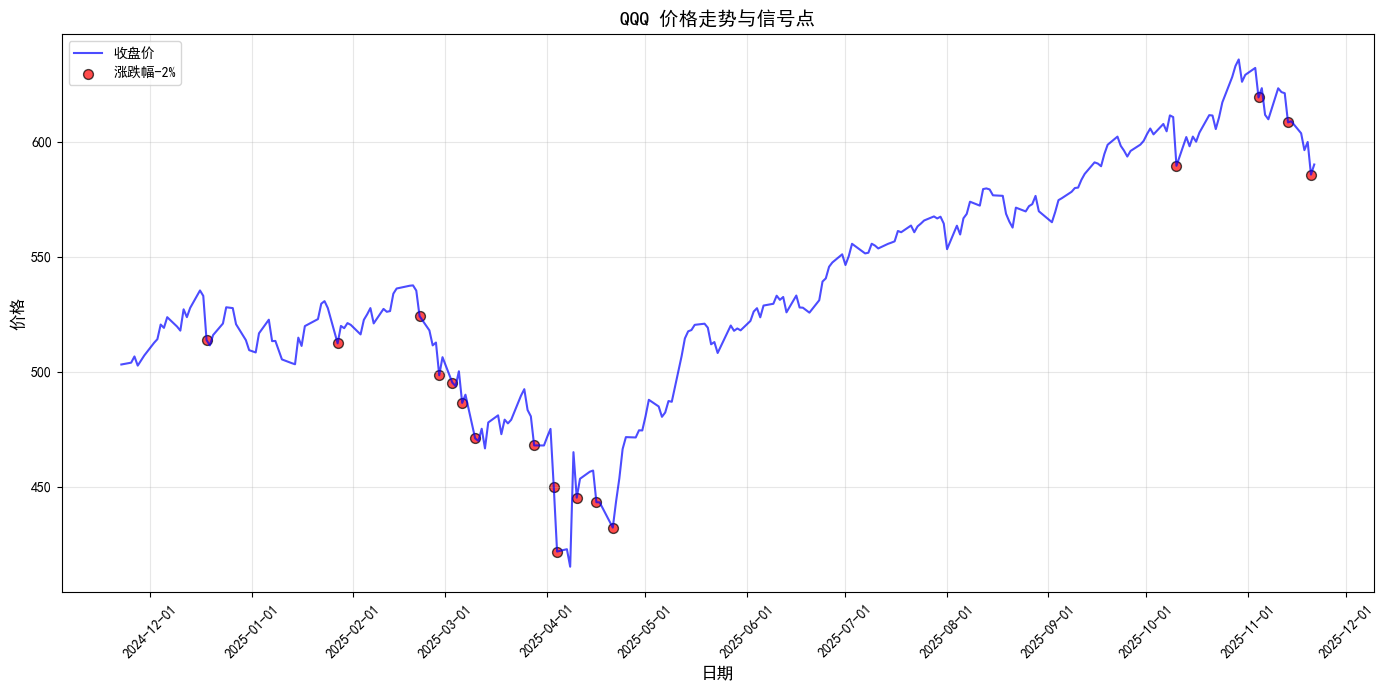

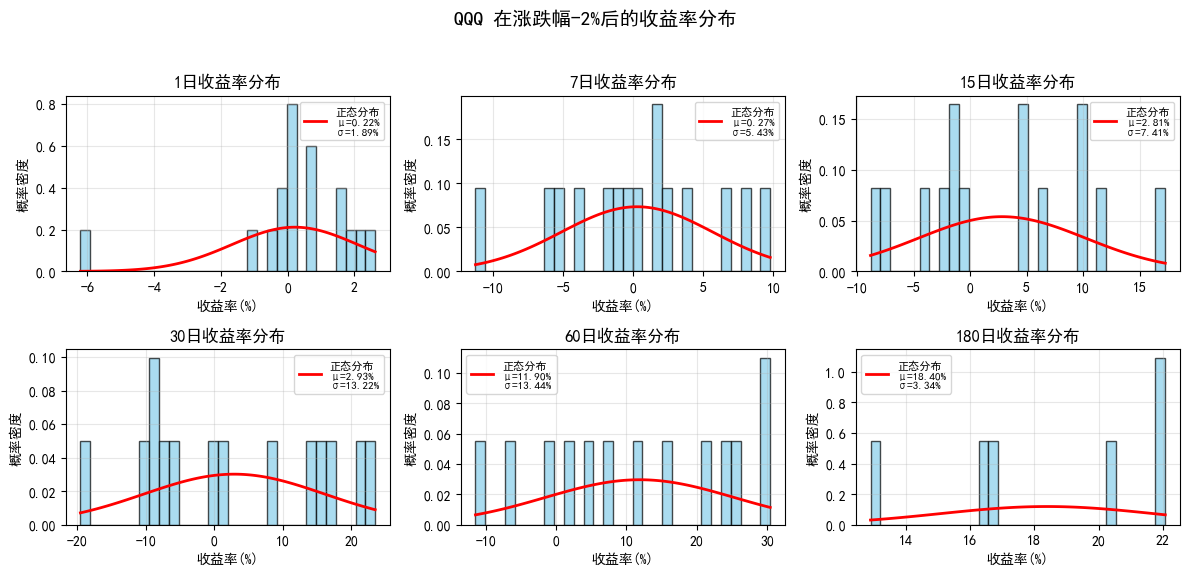

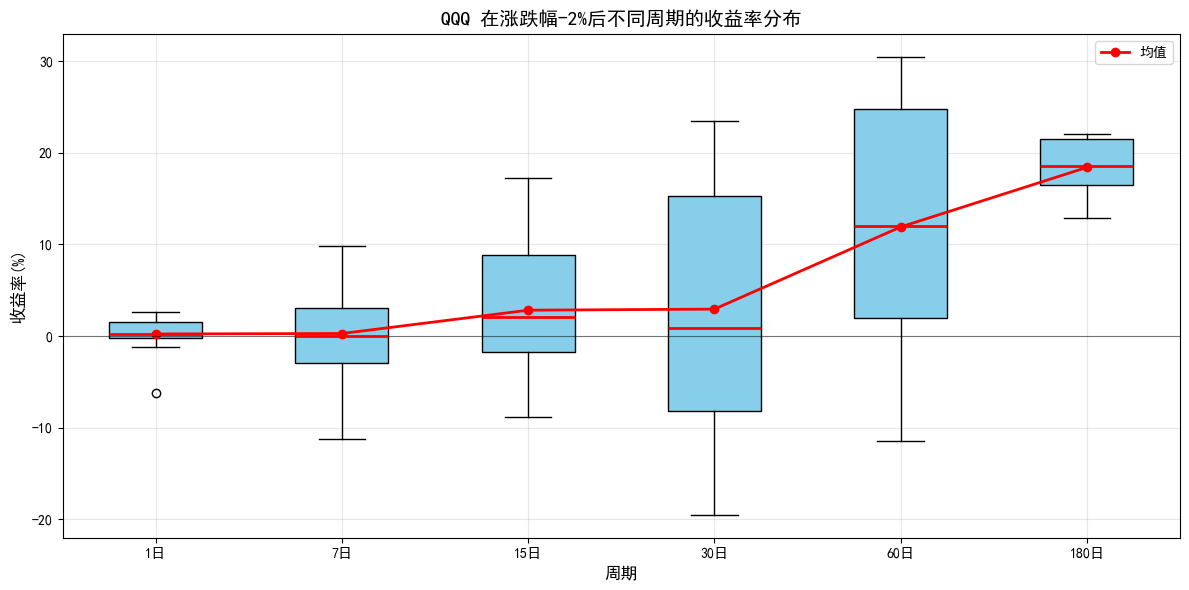

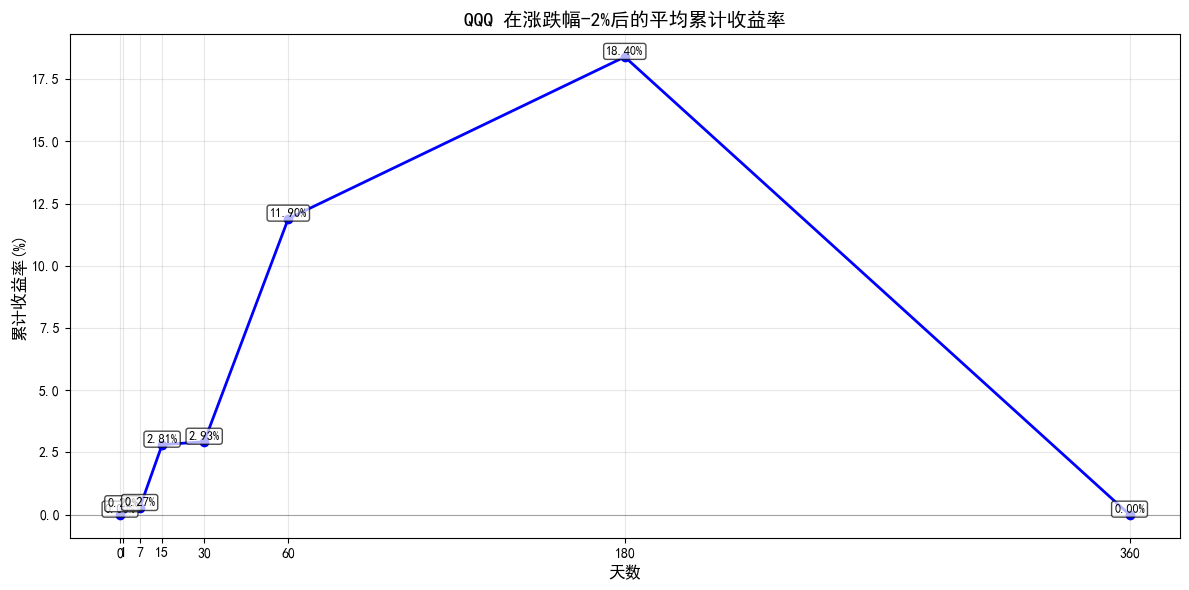


统计分析结果:
----------------------------------------------------------------------------------------------------
周期       样本数      均值(%)      中位数(%)       标准差(%)       最小值(%)       最大值(%)       正收益比例(%)        偏度         峰度        
----------------------------------------------------------------------------------------------------
 1日    17       0.22       0.24         1.89         -6.21        2.63         58.8            -2.09      5.21      
 7日    15       0.27       -0.01        5.43         -11.28       9.78         46.7            -0.16      -0.34     
15日    14       2.81       2.10         7.41         -8.82        17.26        50.0            0.20       -0.90     
30日    14       2.93       0.90         13.22        -19.54       23.50        57.1            0.09       -1.29     
60日    13       11.90      12.02        13.44        -11.47       30.46        76.9            -0.15      -1.23     
180日    6        18.40      18.58        3.34         12.91        22.07        100.0

In [32]:
# 配置分析参数
ticker = "QQQ"  # 股票代码，例如：AAPL, MSFT, TSLA, 600000.SS(沪市), 000001.SZ(深市)
target_change = -2  # 目标涨跌幅百分比，正数为涨幅，负数为跌幅
period = '1y'  # 数据周期，可选值：1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
use_cache = True  # 是否使用缓存数据
generate_html = False  # 是否生成HTML报告
html_filename = f"{ticker}_{target_change}_analysis.html"  # HTML报告文件名

# 创建分析器并运行分析
analyzer = StockVolatilityAnalyzer(ticker, target_change, period, use_cache)
results = analyzer.run_analysis(show_plots=True)  # show_plots控制是否在Notebook中显示图表

# 生成HTML报告（如果需要）
if generate_html and results:
    save_results_to_html(results, html_filename)

### 使用说明
1. 在上方代码块中修改分析参数：
   - `ticker`：股票代码，例如美股使用"AAPL"，沪市股票使用"600000.SS"，深市股票使用"000001.SZ"
   - `target_change`：目标涨跌幅百分比，正数表示涨幅，负数表示跌幅
   - `period`：数据周期，可选值包括1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
   - `use_cache`：是否使用缓存数据，首次运行建议设为True
   - `generate_html`：是否生成HTML报告，设为True则生成，False则不生成
   - `html_filename`：HTML报告的文件名

2. 运行代码块即可执行分析并在Notebook中显示图表
3. 如果设置了生成HTML报告，分析完成后会在当前目录生成对应的HTML文件